# 🌎📡 Satellite images classification using Vision Transformers

***

@Agata Polejowska

## 📁 Set up the environment

#### Installing dependencies

In [ ]:
!pip install -q wandb
!pip install -q fastai
!pip install -q datasets transformers
!pip install -q plotly-express
!pip install -U gdown -q

     |████████████████████████████████| 1.9 MB 36.1 MB/s 
     |████████████████████████████████| 182 kB 68.3 MB/s 
     |████████████████████████████████| 173 kB 73.1 MB/s 
     |████████████████████████████████| 62 kB 1.6 MB/s 
     |████████████████████████████████| 168 kB 79.9 MB/s 
     |████████████████████████████████| 168 kB 85.6 MB/s 
     |████████████████████████████████| 166 kB 74.7 MB/s 
     |████████████████████████████████| 166 kB 58.9 MB/s 
     |████████████████████████████████| 162 kB 73.0 MB/s 
     |████████████████████████████████| 162 kB 72.7 MB/s 
     |████████████████████████████████| 158 kB 74.7 MB/s 
     |████████████████████████████████| 157 kB 84.5 MB/s 
     |████████████████████████████████| 157 kB 78.3 MB/s 
     |████████████████████████████████| 157 kB 81.5 MB/s 
     |████████████████████████████████| 157 kB 76.1 MB/s 
     |████████████████████████████████| 157 kB 77.6 MB/s 
     |████████████████████████████████| 157 kB 77.8 MB/s 
     |██████████

#### Importing libraries and logging

In [ ]:
from huggingface_hub import notebook_login


notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


In [ ]:
import wandb


wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
from datasets import load_dataset, load_metric
from transformers import AutoFeatureExtractor, AutoModelForImageClassification, TrainingArguments, Trainer

import torch
from torchvision.transforms import (
    Compose,
    Normalize,
    Resize,
    ToTensor,
)
from fastai.vision.all import untar_data, Path, progress_bar, get_image_files

import numpy as np
from tqdm import tqdm

from PIL import Image
import requests

import zipfile
import os
from io import BytesIO
import gdown
import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import confusion_matrix, accuracy_score

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

## 📚 Loading the dataset



In [ ]:
URL = "https://madm.dfki.de/files/sentinel/EuroSAT.zip"

In [ ]:
path = Path(untar_data(URL, force_download=True))
path.ls()

In [ ]:
dataset = load_dataset(
    "imagefolder",
    data_files=URL
)
dataset

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-71c8f80171b09b95/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 27000
    })
})

In [ ]:
dataset = dataset["train"].train_test_split(test_size=0.3, stratify_by_column="label", seed=42)

dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 18900
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 8100
    })
})

In [ ]:
dataset_split = dataset["test"].train_test_split(test_size=0.5, stratify_by_column="label", seed=42)

dataset["valid"] = dataset_split["train"]
dataset["test"] = dataset_split["test"]

dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 18900
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 4050
    })
    valid: Dataset({
        features: ['image', 'label'],
        num_rows: 4050
    })
})

### Get labels ids and class names mapping

In [ ]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

In [ ]:
print(f"label2id: {label2id}")
print(f"id2label: {id2label}")

label2id: {'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}
id2label: {0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'}


## 🔍 Explore the dataset

In [ ]:
num_classes = len(dataset["train"].features["label"].names)
class_names = dataset["train"].features["label"].names
num_training_examples = len(dataset["train"])
dataset_features = dataset["train"].features

print(f"Dataset structure: {dataset}\n")
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")
print(f"Number of training examples: {num_training_examples}")
print(f"Dataset features: {dataset_features}")

Dataset structure: DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 18900
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 4050
    })
    valid: Dataset({
        features: ['image', 'label'],
        num_rows: 4050
    })
})

Number of classes: 10
Class names: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Number of training examples: 18900
Dataset features: {'image': Image(decode=True, id=None), 'label': ClassLabel(names=['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake'], id=None)}


#### 🗺️ Visualize data and display essential information

In [ ]:
def plot_class_distribution(dataset, id2label, dataset_name="dataset"):
    fig = px.histogram(
        x=[id2label[label] for label in dataset["label"]],
        title=f"Distribution of classes in the {dataset_name} dataset",
    )
    fig.update_layout(xaxis_title="Class", yaxis_title="Number of examples")
    fig.show()
    return fig

In [ ]:
train_dataset_fig = plot_class_distribution(dataset["train"], id2label, "train")
valid_dataset_fig = plot_class_distribution(dataset["valid"], id2label, "valid")
test_dataset_fig = plot_class_distribution(dataset["test"], id2label, "test")

In [ ]:
def display_random_images(dataset, label2id, id2label):
    fig = plt.figure(figsize=(10, 10))
    for i in range(4):
        random_image = np.random.randint(0, len(dataset))
        image = dataset[random_image]["image"]
        label = dataset[random_image]["label"]
        class_name = id2label[label]

        ax = fig.add_subplot(2, 2, i + 1)
        ax.imshow(image)
        ax.set_title(f"Class: {label} ({class_name})")
        ax.axis("off")
    plt.show()

    return fig

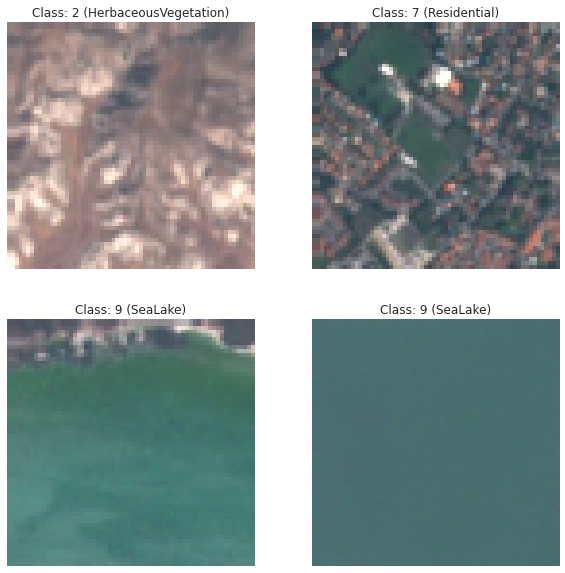

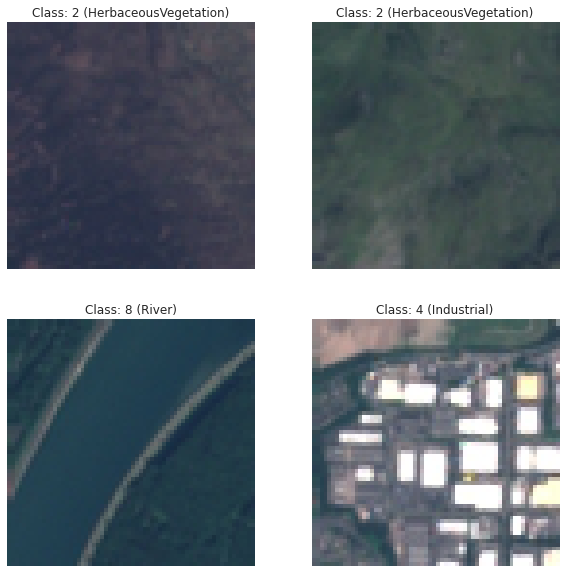

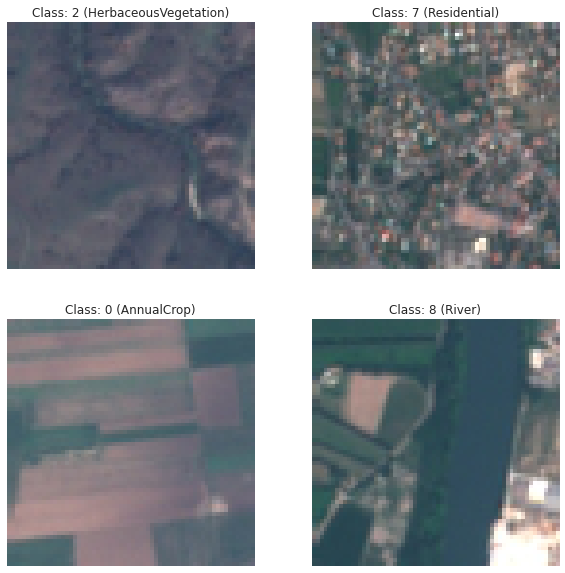

In [ ]:
random_images_train = display_random_images(dataset["train"], label2id, id2label)
random_images_valid = display_random_images(dataset["valid"], label2id, id2label)
random_images_test = display_random_images(dataset["test"], label2id, id2label)

## W&B logging

In [ ]:
PROJECT = 'eurosat-vits'
ENTITY = 'polejowska'

In [ ]:
# RAW_DATA_AT = "eurosat"

# run = wandb.init(project=PROJECT, entity=ENTITY, job_type="upload")

# raw_data_at = wandb.Artifact(RAW_DATA_AT, type="raw_data")

# for class_name in class_names:
#   raw_data_at.add_dir(path/class_name, name='class_name')


# for class_name in class_names:
#   raw_data_at.add_dir(path/class_name, name='class_name')

# run.finish()

In [ ]:
run = wandb.init(project=PROJECT, entity=ENTITY)

In [ ]:
def _create_wandb_table(dataset):
    table = wandb.Table(columns=["image", "class_id", "class_name"])
    
    for i in range(len(dataset)):
        image = dataset[i]["image"]
        label = dataset[i]["label"]
        class_name = id2label[label]
        table.add_data(
            wandb.Image(image),
            label,
            class_name,
        )
    
    return table

In [ ]:
train_table = _create_wandb_table(dataset["train"])
valid_table = _create_wandb_table(dataset["valid"])
test_table = _create_wandb_table(dataset["test"])

In [ ]:
run.log({"train": train_table, "valid": valid_table, "test": test_table})
run.log({'train_dataset_fig': train_dataset_fig})
run.log({'test_dataset_fig': test_dataset_fig})
run.log({'valid_dataset_fig': valid_dataset_fig})
run.log({'random_images_train': random_images_train})
run.log({'random_images_valid': random_images_valid})
run.log({'random_images_test': random_images_test})

***
## 🔨 Data preparation

1. Resize images
2. Normalize RGB channels using mean and standard deviation

In [ ]:
# raw_data_at = run.use_artifact(f'{RAW_DATA_AT}:latest')
# path = Path(raw_data_at.download())
# path.ls()

In [ ]:
# model_checkpoint = "microsoft/swin-tiny-patch4-window7-224"
# model_checkpoint = "facebook/convnext-tiny-224"
model_checkpoint = "google/vit-base-patch16-224-in21k"

feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)
resize_value = (224, 224)

data_transforms = Compose(
        [
            Resize(resize_value),
            ToTensor(),
            Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
        ]
)

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

loading configuration file preprocessor_config.json from cache at /root/.cache/huggingface/hub/models--google--vit-base-patch16-224-in21k/snapshots/1ba429d32753f33a0660b80ac6f43a3c80c18938/preprocessor_config.json


Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--vit-base-patch16-224-in21k/snapshots/1ba429d32753f33a0660b80ac6f43a3c80c18938/config.json
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.25.1"
}

{param_name} should be a dictionary on of the following set of keys: {VALID_SIZE_DICT_KEYS}, got {size}. Converted to {size_dict}.
Image processor ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.

In [ ]:
def add_pixel_values_feature(batch):
  batch["pixel_values"] = [
        data_transforms(image.convert("RGB")) for image in batch["image"]
  ]
  return batch

In [ ]:
train_dataset = dataset["train"]
valid_dataset = dataset["valid"]
test_dataset = dataset["test"]

train_dataset.set_transform(add_pixel_values_feature)
valid_dataset.set_transform(add_pixel_values_feature)
test_dataset.set_transform(add_pixel_values_feature)

***
## 🚋 Model training

In [ ]:
def collate_fn(batches):
    pixel_values = torch.stack([batch["pixel_values"] for batch in batches])
    labels = torch.tensor([batch["label"] for batch in batches])
    return {"pixel_values": pixel_values, "labels": labels}


def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return accuracy_metric.compute(predictions=predictions, references=eval_pred.label_ids)


accuracy_metric = load_metric("accuracy")

<ipython-input-25-7d6619bbc586>:12: FutureWarning:

load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate



In [ ]:
model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint, 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,
)

MODEL_NAME = model_checkpoint.split("/")[-1]
NUM_TRAIN_EPOCHS = 5
LEARNING_RATE = 5e-5
BATCH_SIZE = 32
STRATEGY = "epoch"
wandb.run.name = f"{MODEL_NAME} (epochs: {NUM_TRAIN_EPOCHS})"
wandb.watch(model)

args = TrainingArguments(
    f"vit-{MODEL_NAME}-eurosat",
    remove_unused_columns=False,
    evaluation_strategy=STRATEGY,
    save_strategy=STRATEGY,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_TRAIN_EPOCHS,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="wandb",
    push_to_hub=True,
)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--vit-base-patch16-224-in21k/snapshots/1ba429d32753f33a0660b80ac6f43a3c80c18938/config.json
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "AnnualCrop",
    "1": "Forest",
    "2": "HerbaceousVegetation",
    "3": "Highway",
    "4": "Industrial",
    "5": "Pasture",
    "6": "PermanentCrop",
    "7": "Residential",
    "8": "River",
    "9": "SeaLake"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "AnnualCrop": 0,
    "Forest": 1,
    "HerbaceousVegetation": 2,
    "Highway": 3,
    "Industrial": 4,
    "Pasture": 5,
    "PermanentCrop": 6,
    "Residential": 7,
    "River": 8,
    "SeaLake": 9
  },


Downloading:   0%|          | 0.00/346M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--google--vit-base-patch16-224-in21k/snapshots/1ba429d32753f33a0660b80ac6f43a3c80c18938/pytorch_model.bin
Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly ini

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=feature_extractor,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
)

/usr/local/lib/python3.8/dist-packages/huggingface_hub/repository.py:725: FutureWarning:

Creating a repository through 'clone_from' is deprecated and will be removed in v0.12. Please create the repository first using `create_repo(..., exists_ok=True)`.

Cloning https://huggingface.co/polejowska/vit-vit-base-patch16-224-in21k-eurosat into local empty directory.


In [ ]:
trainer_results = trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning

***** Running training *****
  Num examples = 18900
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 735
  Number of trainable parameters = 85806346
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


***** Running Evaluation *****
  Num examples = 4050
  Batch size = 32
Saving model checkpoint to vit-vit-base-patch16-224-in21k-eurosat/checkpoint-147
Configuration saved in vit-vit-base-patch16-224-in21k-eurosat/checkpoint-147/config.json
Model weights saved in vit-vit-base-patch16-224-in21k-eurosat/checkpoint-147/pytorch_model.bin
Image processor saved in vit-vit-base-patch16-224-in21k-eurosat/checkpoint-147/preprocessor_config.json
Image processor saved in vit-vit-base-patch16-224-in21k-eurosat/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 4050
  Batch size = 32
Saving model checkpoint to vit-vit-base-patch16-224-in21k-eurosat/checkpoint-294
Configuration saved in vit-vit-base-patch16-224-in21k-eurosat/checkpoint-294/config.json
Model weights saved in vit-vit-base-patch16-224-in21k-eurosat/checkpoint-294/pytorch_model.bin
Image processor saved in vit-vit-base-patch16-224-in21k-eurosat/checkpoint-294/preprocessor_config.json
***** Running Evaluation *****


In [ ]:
# trainer.save_model()

trainer.log_metrics("train", trainer_results.metrics)
trainer.save_metrics("train", trainer_results.metrics)

trainer.save_state()

***** train metrics *****
  epoch                    =         4.99
  total_flos               = 6814495002GF
  train_loss               =       0.3139
  train_runtime            =   0:57:01.39
  train_samples_per_second =        27.62
  train_steps_per_second   =        0.215


## 📈 Model evaluation

In [ ]:
metrics = trainer.evaluate()

trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 4050
  Batch size = 32


***** eval metrics *****
  epoch                   =       4.99
  eval_accuracy           =     0.9886
  eval_loss               =     0.0957
  eval_runtime            = 0:00:51.97
  eval_samples_per_second =      77.92
  eval_steps_per_second   =      2.443


In [ ]:
trainer.push_to_hub()

Saving model checkpoint to vit-vit-base-patch16-224-in21k-eurosat
Configuration saved in vit-vit-base-patch16-224-in21k-eurosat/config.json
Model weights saved in vit-vit-base-patch16-224-in21k-eurosat/pytorch_model.bin
Image processor saved in vit-vit-base-patch16-224-in21k-eurosat/preprocessor_config.json
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 3.30k/327M [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/polejowska/vit-vit-base-patch16-224-in21k-eurosat
   8107fe6..b9ca2fa  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/polejowska/vit-vit-base-patch16-224-in21k-eurosat
   8107fe6..b9ca2fa  main -> main

To https://huggingface.co/polejowska/vit-vit-base-patch16-224-in21k-eurosat
   b9ca2fa..313eb92  main -> main

   b9ca2fa..313eb92  main -> main



'https://huggingface.co/polejowska/vit-vit-base-patch16-224-in21k-eurosat/commit/b9ca2fa850a9414e6c58abf5385d31c28f8330bf'

In [ ]:
def create_table_with_predictions(dataset, predictions):
    table = wandb.Table(columns=["image", "label", "class name", "prediction", "prediction class name"])

    for i in tqdm(range(len(dataset))):
        image, label = dataset[i]["image"], dataset[i]["label"]
        table.add_data(wandb.Image(image), label, id2label[label], predictions[i], id2label[predictions[i]])

    return table

In [ ]:
test_predictions = np.argmax(trainer.predict(test_dataset).predictions, axis=1)
test_table_with_predictions = create_table_with_predictions(test_dataset, test_predictions)

wandb.log({"test_dataset_table_with_predictions": test_table_with_predictions})

***** Running Prediction *****
  Num examples = 4050
  Batch size = 32


100%|██████████| 4050/4050 [00:22<00:00, 181.66it/s]


In [ ]:
confusion_matrix_plot = wandb.plot.confusion_matrix(
    probs=None,
    y_true=test_dataset[:]["label"],
    preds=test_predictions,
    class_names=list(id2label.values()),
)

wandb.log({"confusion_matrix": confusion_matrix_plot})

In [ ]:
def plot_confusion_matrix(cm, class_names):
    fig = go.Figure(data=go.Heatmap(z=cm, x=class_names, y=class_names))
    fig.update_layout(
        title="Confusion Matrix",
        xaxis_title="Predicted label",
        yaxis_title="True label",
        annotations=[go.layout.Annotation(
            text=str(round(z, 2)), x=x, y=y, font_size=14, showarrow=False) 
        for x, y, z in zip(
            np.tile(class_names, len(class_names)), np.repeat(class_names, len(class_names)), cm.flatten())],
            )
    fig.show()
    return fig


cm = confusion_matrix(test_dataset[:]["label"], test_predictions)
cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
cm_plot = plot_confusion_matrix(cm, list(id2label.values()))

wandb.log({"confusion_matrix (plotly)": cm_plot})

In [ ]:
test_accuracy = accuracy_score(test_dataset[:]["label"], test_predictions)
print("Accuracy: {:.2f}%".format(test_accuracy*100))

Accuracy: 98.67%


In [ ]:
run.log({"Test accuracy": test_accuracy})

In [ ]:
run.log({f"Test dataset accuracy": wandb.Html(f"""<h1 style="text-align: center;">{round(test_accuracy*100, 3)}%</h1>""")})

In [ ]:
run.finish()

## 🌐 Inference

In [ ]:
imgs_urls = [
    "https://huggingface.co/polejowska/swin-tiny-patch4-window7-224-eurosat/resolve/main/GoogleEarth/Zrzut%20ekranu%202022-12-10%20110307.png",
    "https://huggingface.co/polejowska/swin-tiny-patch4-window7-224-eurosat/resolve/main/GoogleEarth/Zrzut%20ekranu%202022-12-10%20110454.png",
    "https://huggingface.co/polejowska/swin-tiny-patch4-window7-224-eurosat/resolve/main/GoogleEarth/Zrzut%20ekranu%202022-12-10%20110708.png",
    "https://huggingface.co/polejowska/swin-tiny-patch4-window7-224-eurosat/resolve/main/GoogleEarth/Zrzut%20ekranu%202022-12-10%20114336.png",
    "https://huggingface.co/polejowska/swin-tiny-patch4-window7-224-eurosat/resolve/main/GoogleEarth/Zrzut%20ekranu%202022-12-10%20113158.png",
]

imgs = [Image.open(requests.get(img_url, stream=True).raw).convert('RGB') for img_url in imgs_urls]

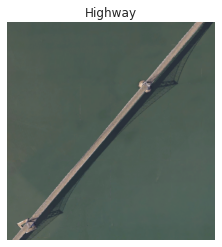

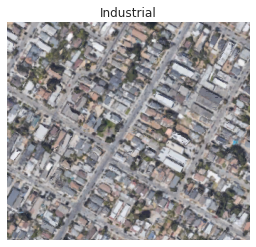

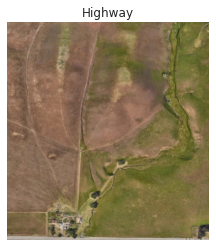

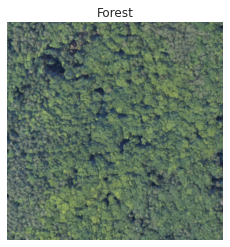

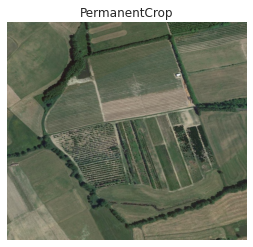

In [ ]:
def predict(feature_extractor, model, images, device):
  resize_value = (224, 224)

  inference_data_transforms = Compose(
          [
              Resize(resize_value),
              ToTensor(),
              Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
          ]
      )
  
  encodings = [feature_extractor(image.convert("RGB"), return_tensors="pt").to(device) for image in images]

  predicted_class_idxs = []

  for i, encoding in enumerate(encodings):
    with torch.no_grad():
      outputs = model(**encoding)
      logits = outputs.logits

      predicted_class_idxs.append(logits.argmax(-1).item())
      predicted_class_name = model.config.id2label[predicted_class_idxs[i]]

      plt.imshow(images[i])
      plt.title(f"{predicted_class_name}")
      plt.axis("off")
      plt.show()


  return predicted_class_idxs


device = "cuda:0"
predicted_class_idxs = predict(feature_extractor, model, imgs, device)
wandb.log(
    {"inference_images": 
     [wandb.Image(
         image,
         caption=f"Predicted class: {predicted_class_idxs[i]} {model.config.id2label[predicted_class_idxs[i]]}")
     for i, image in enumerate(imgs)]})

## 🔥 Attention heatmaps

The DINO model is used for visualizing attention maps.
Attention maps are overlayed on the input images.

In [ ]:
run = wandb.init(project=PROJECT, entity=ENTITY)
wandb.run.name = "attention-maps"

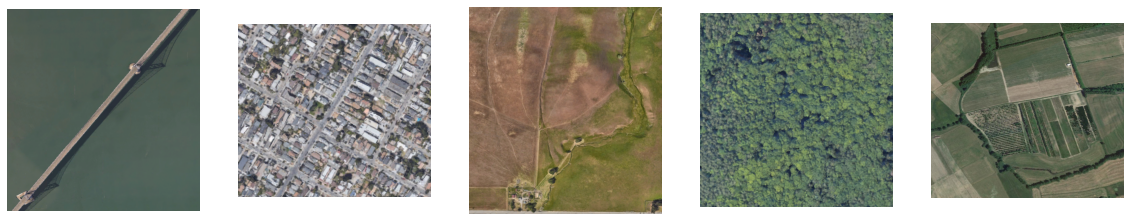

In [ ]:
def load_image_from_url(url):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content)).convert('RGB')
    return image


img_url = 'https://huggingface.co/polejowska/swin-tiny-patch4-window7-224-finetuned-eurosat/resolve/main/GoogleEarth/Zrzut%20ekranu%202022-12-10%20110307.png'
image = load_image_from_url(img_url)

imgs_urls = [
    "https://huggingface.co/polejowska/swin-tiny-patch4-window7-224-eurosat/resolve/main/GoogleEarth/Zrzut%20ekranu%202022-12-10%20110307.png",
    "https://huggingface.co/polejowska/swin-tiny-patch4-window7-224-eurosat/resolve/main/GoogleEarth/Zrzut%20ekranu%202022-12-10%20110454.png",
    "https://huggingface.co/polejowska/swin-tiny-patch4-window7-224-eurosat/resolve/main/GoogleEarth/Zrzut%20ekranu%202022-12-10%20110708.png",
    "https://huggingface.co/polejowska/swin-tiny-patch4-window7-224-eurosat/resolve/main/GoogleEarth/Zrzut%20ekranu%202022-12-10%20114336.png",
    "https://huggingface.co/polejowska/swin-tiny-patch4-window7-224-eurosat/resolve/main/GoogleEarth/Zrzut%20ekranu%202022-12-10%20113158.png",
]
imgs = [load_image_from_url(img_url) for img_url in imgs_urls]

fig, axs = plt.subplots(1, len(imgs), figsize=(20, 20))
for i, img in enumerate(imgs):
    axs[i].imshow(img)
    axs[i].axis('off')
plt.show()

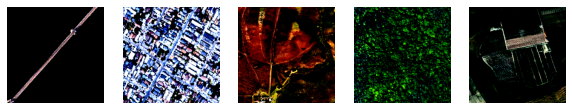

In [ ]:
def preprocess_image(image, size=224):
    crop_layer = keras.layers.CenterCrop(224, 224)
    norm_layer = keras.layers.Normalization(
        mean=[0.485 * 255, 0.456 * 255, 0.406 * 255],
        variance=[(0.229 * 255) ** 2, (0.224 * 255) ** 2, (0.225 * 255) ** 2],
    )
    rescale_layer = keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1)
    image = np.array(image)
    image = tf.expand_dims(image, 0)
    resize_size = int((256 / 224) * size)
    image = tf.image.resize(image, (resize_size, resize_size), method="bicubic")
    image = crop_layer(image)
    image = norm_layer(image)
    return image.numpy()


preprocessed_image = preprocess_image(image)
preprocessed_images = [preprocess_image(img) for img in imgs]

plt.figure(figsize=(10, 10))
for i, image in enumerate(preprocessed_images):
    ax = plt.subplot(1, len(preprocessed_images), i + 1)
    plt.imshow(image[0])
    plt.axis("off")

In [ ]:
def get_gdrive_model(model_id: str) -> tf.keras.Model:
  model_path = gdown.download(id=model_id, quiet=False)
  with zipfile.ZipFile(model_path, "r") as zip_ref:
      zip_ref.extractall()
  model_name = model_path.split(".")[0]
  inputs = keras.Input((224, 224, 3))
  model = keras.models.load_model(model_name, compile=False)
  outputs, attention_weights = model(inputs)
  return keras.Model(inputs, outputs=[outputs, attention_weights])


def get_model(id):
  loaded_model = get_gdrive_model(id)
  return loaded_model


vit_dino_base16 = get_model("16_1oDm0PeCGJ_KGBG5UKVN7TsAtiRNrN")

Downloading...
From: https://drive.google.com/uc?id=16_1oDm0PeCGJ_KGBG5UKVN7TsAtiRNrN
To: /content/vit_dino_base16.zip
100%|██████████| 326M/326M [00:03<00:00, 93.8MB/s]


In [ ]:
predictions, attention_score_dict = vit_dino_base16.predict(preprocessed_image)

1/1 [==============================] - 2s 2s/step


In [ ]:
predictions_attention_score_dict = {}

for i, image in enumerate(preprocessed_images):
    predictions, attention_score_dict = vit_dino_base16.predict(image)
    predictions_attention_score_dict[i] = attention_score_dict

1/1 [==============================] - 0s 74ms/step


In [ ]:
def attention_heatmap(attention_score_dict, image, patch_size=16):
    num_tokens = 1
    num_heads = 12
    attention_score_list = list(attention_score_dict.keys())
    attention_score_list.sort(key=lambda x: int(x.split("_")[-2]), reverse=True)
    w_featmap = image.shape[2] // patch_size
    h_featmap = image.shape[1] // patch_size
    attention_scores = attention_score_dict[attention_score_list[0]]
    attentions = attention_scores[0, :, 0, num_tokens:].reshape(num_heads, -1)
    attentions = attentions.reshape(num_heads, w_featmap, h_featmap)
    attentions = attentions.transpose((1, 2, 0))
    attentions = tf.image.resize(
        attentions, size=(h_featmap * patch_size, w_featmap * patch_size)
    )
    return attentions


def denormalize_image(image):
    in1k_mean = tf.constant([0.485 * 255, 0.456 * 255, 0.406 * 255])
    in1k_std = tf.constant([0.229 * 255, 0.224 * 255, 0.225 * 255])
    image = (image * in1k_std) + in1k_mean
    image = image / 255.0
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image


def plot_attention_heatmap(attention_score_dict, preprocessed_img_orig):
    image = denormalize_image(preprocessed_img_orig)
    attentions = attention_heatmap(attention_score_dict, image)
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(13, 13))
    img_count = 0
    # plot the original image
    # plot the attention maps and show the scale bar
    for i in range(3):
        axes[i, 0].imshow(image[0])
        axes[i, 0].title.set_text("Original image")
        axes[i, 0].axis("off")
        for j in range(1, 4):
            axes[i, j].imshow(attentions[:, :, img_count])
            axes[i, j].title.set_text(f"Head {img_count + 1}")
            axes[i, j].axis("off")
            img_count += 1
    plt.tight_layout()
    plt.show()
    fig.canvas.draw()
    data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep="")
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    wandb.log({"attention_heatmap": [wandb.Image(data)]})
    wandb.log({"attention_heads attention maps": fig})
    return fig

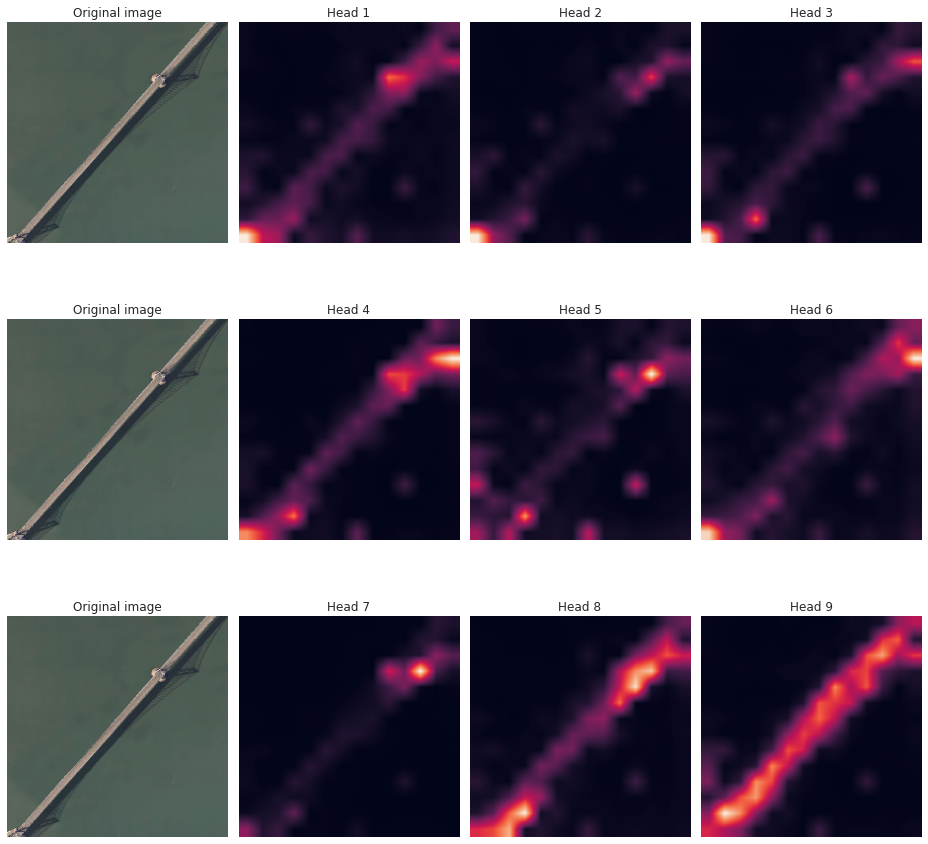

<ipython-input-123-51582e711cf8>:46: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



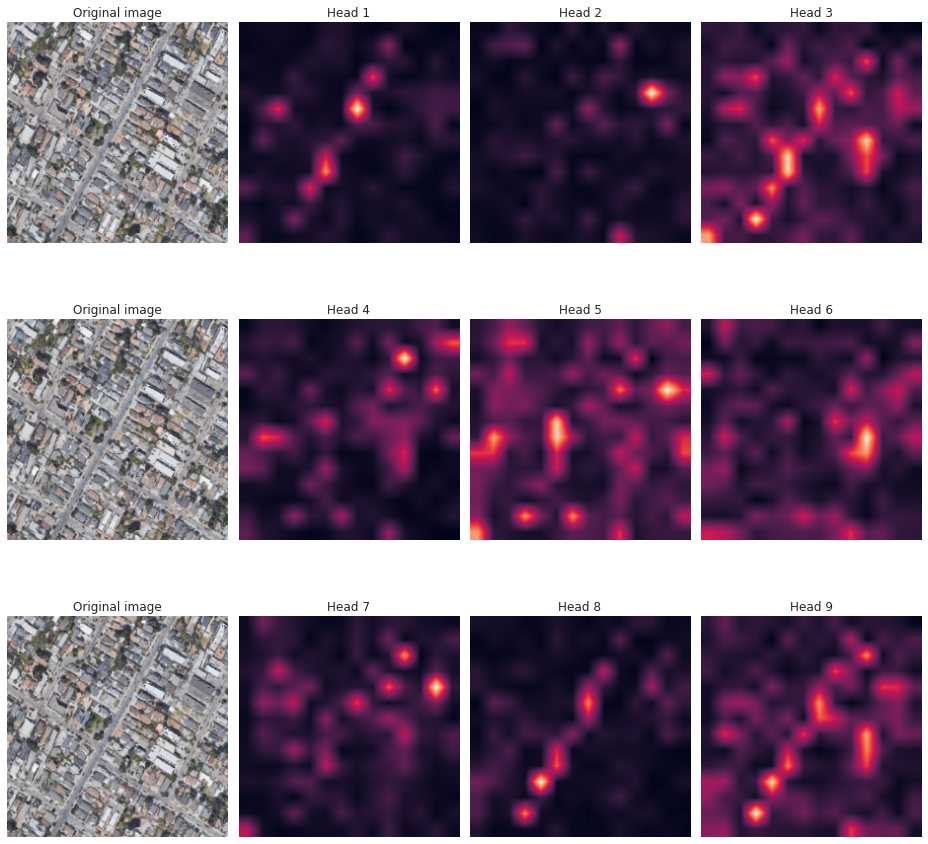

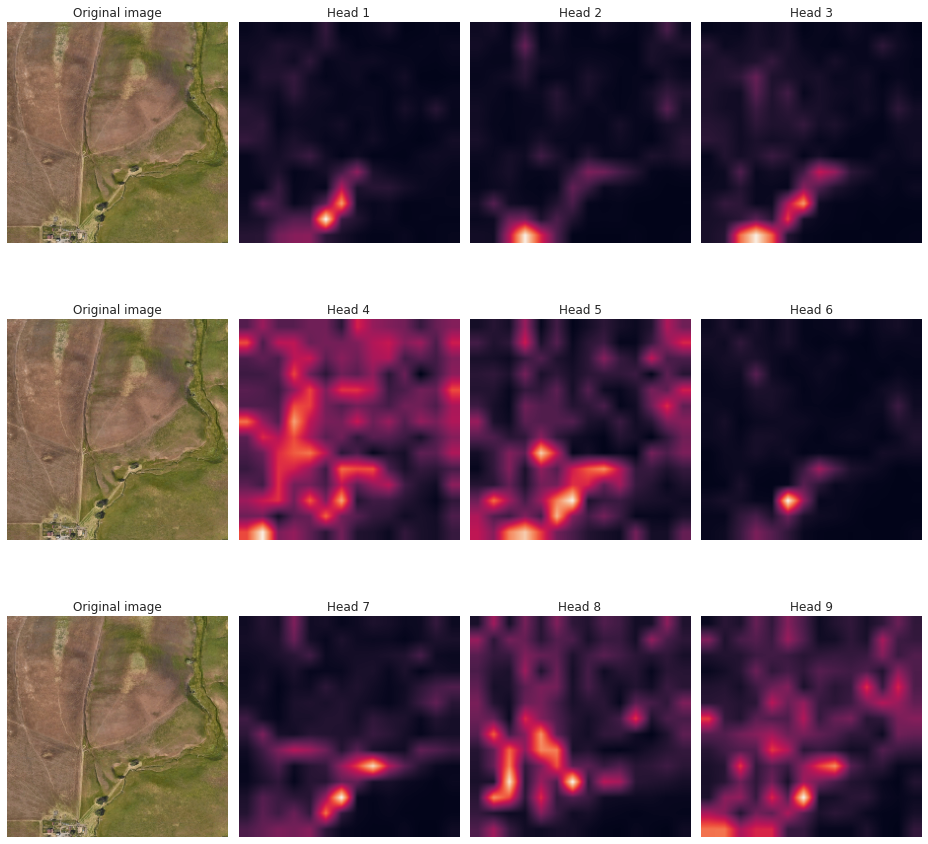

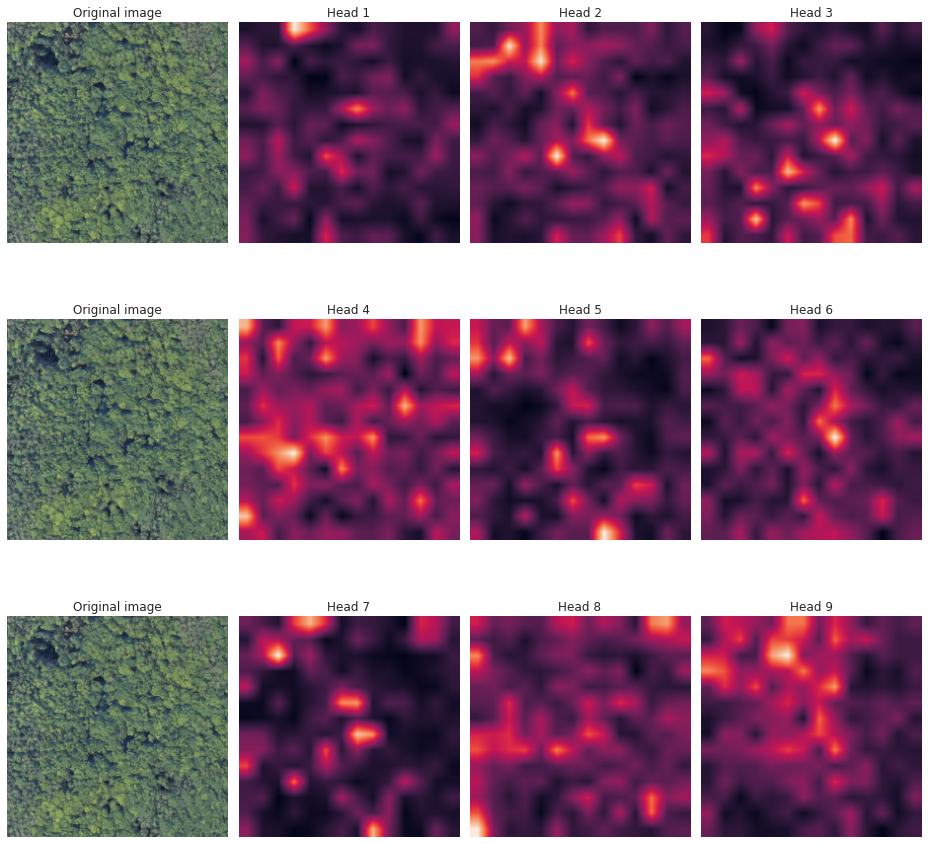

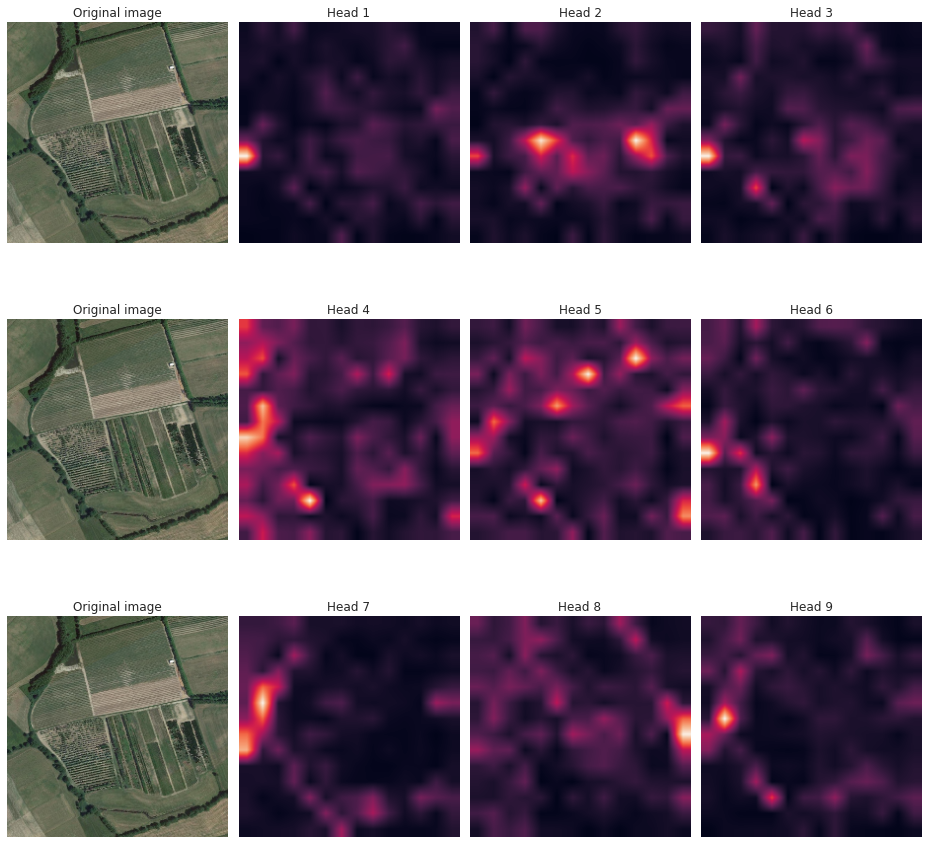

In [ ]:
for i in range(len(imgs)):
  plot_attention_heatmap(predictions_attention_score_dict[i], preprocessed_images[i])

In [ ]:
test_dataset_maps = [img['image'] for img in test_dataset]
test_dataset_maps = test_dataset_maps[:200]
test_dataset_maps

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64>,
 <PIL.JpegImagePlugin.JpegImageFile imag

In [ ]:
len(test_dataset_maps)

200

In [ ]:
processed_images_testdataset = [preprocess_image(img) for img in test_dataset_maps]
for i, image in enumerate(processed_images_testdataset):
    predictions, attention_score_dict = vit_dino_base16.predict(image)
    plot_attention_heatmap(attention_score_dict, image)